## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Author </h1>

Билинский Норгей, гр. 932328

### Задание 4. Сегментация изображений
Цель работы: Получить навыки реализации нейронных сетей для семантической сегментации изображений.

Задачи:

1. Выбрать или подготовить набор данных для семантической сегментации (3+ классов).

2. Реализовать базовую версию модели U-net.

3. Настроить параметры модели.

4. Вывести графики обучения модели и метрики точности.

5. Визуализировать результаты сегментации, оценить результаты.

## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Importing libraries </h1>


In [ ]:
!pip install opendatasets


In [ ]:
import os
import shutil
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import opendatasets as od
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv2D,
                                     Conv2DTranspose, Input, MaxPooling2D,
                                     concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Checking the GPU environment </h1>

In [ ]:
!nvidia-smi

Tue Jan 28 10:27:54 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Data download </h1>

In [ ]:
dataset_path = Path('semantic-segmentation-of-underwater-imagery-suim')
if not dataset_path.is_file():
    od.download('https://www.kaggle.com/datasets/ashish2001/semantic-segmentation-of-underwater-imagery-suim')


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: norgey
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ashish2001/semantic-segmentation-of-underwater-imagery-suim


100%|██████████| 176M/176M [00:01<00:00, 97.5MB/s]


In [ ]:
CLASS_COLORS = {
    0: [0, 0, 0],     # Фон
    1: [0, 0, 255],   # Люди (синий)
    2: [0, 255, 0],   # Растения (зеленый)
    3: [0, 255, 255], # Обломки (голубой)
    4: [255, 0, 0],   # Роботы (красный)
    5: [255, 0, 255], # Рифы (фиолетовый)
    6: [255, 255, 0], # Рыбы (желтый)
    7: [255, 255, 255]# Дно (белый)
}

CLASS_NAMES = {
    0: "Фон",
    1: "Люди",
    2: "Растения",
    3: "Обломки",
    4: "Роботы",
    5: "Рифы",
    6: "Рыбы",
    7: "Дно"
}


In [ ]:
root_dir = "semantic-segmentation-of-underwater-imagery-suim"
os.rename(os.path.join(root_dir, "TEST"), os.path.join(root_dir, "Test"))

for folder in ["Train", "Val"]:
    os.makedirs(os.path.join(root_dir, folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(root_dir, folder, "masks"), exist_ok=True)
train_val_dir = os.path.join(root_dir, "train_val")
image_files = sorted(os.listdir(os.path.join(train_val_dir, "images")))
mask_files = sorted(os.listdir(os.path.join(train_val_dir, "masks")))

assert len(image_files) == len(mask_files), "Количество изображений и масок не совпадает!"
assert all(img.split('.')[0] == mask.split('.')[0] for img, mask in zip(image_files, mask_files)), "Имена файлов изображений и масок не совпадают!"

train_images, val_images, train_masks, val_masks = train_test_split(
    image_files, mask_files, test_size=0.1, random_state=42
)

def move_files(file_list, src_dir, dest_dir):
    for file_name in file_list:
        src_path = os.path.join(src_dir, file_name)
        dest_path = os.path.join(dest_dir, file_name)
        shutil.move(src_path, dest_path)

# Перемещаем изображения
move_files(train_images, os.path.join(train_val_dir, "images"), os.path.join(root_dir, "Train", "images"))
move_files(val_images, os.path.join(train_val_dir, "images"), os.path.join(root_dir, "Val", "images"))

# Перемещаем маски
move_files(train_masks, os.path.join(train_val_dir, "masks"), os.path.join(root_dir, "Train", "masks"))
move_files(val_masks, os.path.join(train_val_dir, "masks"), os.path.join(root_dir, "Val", "masks"))

# Удаляем пустую папку train_val
shutil.rmtree(train_val_dir)

def create_dataframes(base_path):
    """
    Создаёт три DataFrame (тренировочный, валидационный и тестовый) из данных по указанному пути.

    Параметры:
        base_path (str или Path): Путь к корневой директории с данными

    Возвращает:
        tuple: Кортеж из трёх DataFrame (train_df, val_df, test_df)
    """
    base_path = Path(base_path)

    def process_split(split_name):
        # Формируем пути к изображениям и маскам
        img_dir = base_path / split_name / "images"
        mask_dir = base_path / split_name / "masks"

        # Получаем и сортируем пути к файлам
        images = sorted(img_dir.glob("*.jpg"))
        masks = sorted(mask_dir.glob("*.bmp"))

        # Проверка соответствия количества файлов
        assert len(images) == len(masks), f"Несоответствие количества изображений и масок в {split_name}"

        # Создаём DataFrame
        return pd.DataFrame({
            'objects': [str(p) for p in images],
            'mask': [str(p) for p in masks]
        })

    # Обрабатываем все наборы данных
    train_df = process_split("Train")
    val_df = process_split("Val")
    test_df = process_split("Test")

    return train_df, val_df, test_df


def visualize_sample(dataframe, index=0, figsize=(15, 15), show=True):
    """
    Визуализирует пример изображения и маски из DataFrame.

    Параметры:
        dataframe (pd.DataFrame): DataFrame с путями к данным
        index (int): Индекс примера для визуализации
        figsize (tuple): Размер фигуры для отображения
        show (bool): Флаг для немедленного отображения графика

    Возвращает:
        tuple: (figure, axes, unique_classes) объекты matplotlib для дополнительной настройки

    Исключения:
        ValueError: Если индекс вне диапазона DataFrame
    """

    # Словарь цветов и классов
    CLASS_COLORS = {
        0: [0, 0, 0],     # Фон
        1: [0, 0, 255],   # Люди (синий)
        2: [0, 255, 0],   # Растения (зеленый)
        3: [0, 255, 255], # Обломки (голубой)
        4: [255, 0, 0],   # Роботы (красный)
        5: [255, 0, 255], # Рифы (фиолетовый)
        6: [255, 255, 0], # Рыбы (желтый)
        7: [255, 255, 255]# Дно (белый)
    }

    # Проверка валидности индекса
    if index < 0 or index >= len(dataframe):
        raise ValueError(f"Некорректный индекс {index}. Доступный диапазон: 0-{len(dataframe)-1}")

    try:
        # Загрузка и конвертация изображений
        img_path = dataframe.iloc[index]['objects']
        mask_path = dataframe.iloc[index]['mask']

        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)

        # Извлечение уникальных цветов из маски
        unique_colors = set(tuple(color) for color in mask.reshape(-1, 3))

        # Сопоставление цветов с классами
        color_to_class = {tuple(value): key for key, value in CLASS_COLORS.items()}
        unique_classes = {color_to_class.get(color, 'Неизвестный класс') for color in unique_colors}

        # Создание фигуры
        fig, axes = plt.subplots(1, 2, figsize=figsize)

        # Визуализация изображения
        axes[0].set_xlabel(f"Размер: {image.shape}")
        axes[0].set_title("Изображение")
        axes[0].imshow(image)
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        # Визуализация маски
        axes[1].set_xlabel(f"Размер: {mask.shape}")
        axes[1].set_title("Маска")
        axes[1].imshow(mask)
        axes[1].set_xticks([])
        axes[1].set_yticks([])

        plt.tight_layout()

        if show:
            plt.show()

        return fig, axes, unique_classes

    except Exception as e:
        plt.close()
        raise RuntimeError(f"Ошибка при загрузке или отображении данных: {str(e)}") from e



train_df.shape: (1372, 2)
val_df.shape: (153, 2)
test_df.shape: (110, 2)


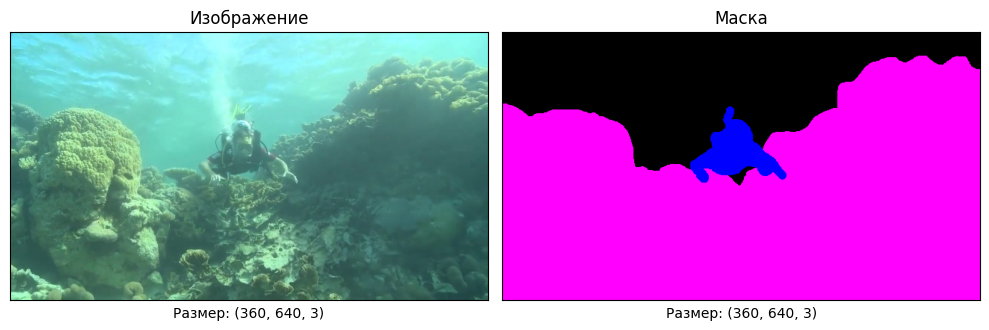

Классы в маске для изображения 57: [(0, 'Фон'), (1, 'Люди'), (5, 'Рифы')]


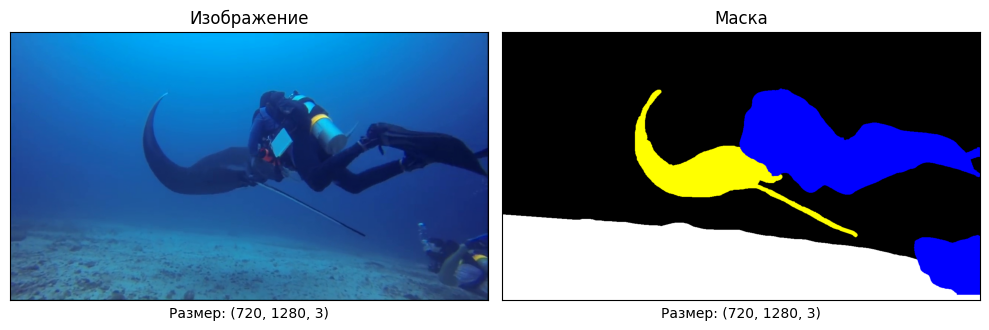

Классы в маске для изображения 12: [(0, 'Фон'), (1, 'Люди'), (6, 'Рыбы'), (7, 'Дно')]


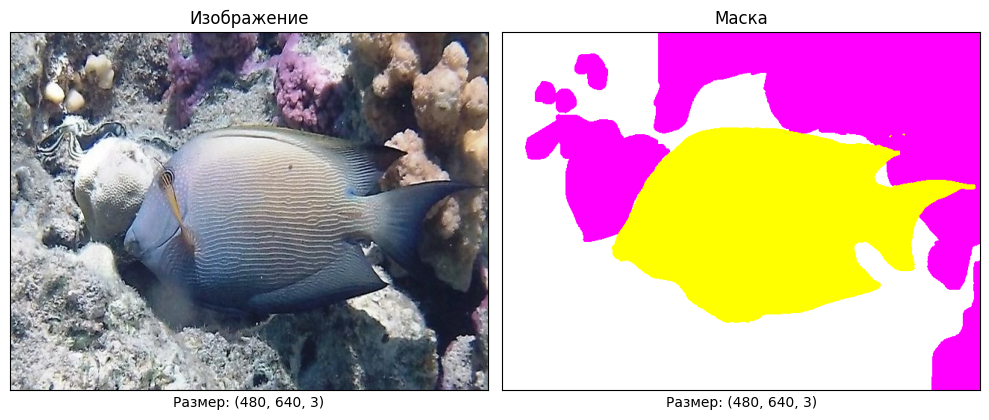

Классы в маске для изображения 1112: [(5, 'Рифы'), (6, 'Рыбы'), (7, 'Дно')]


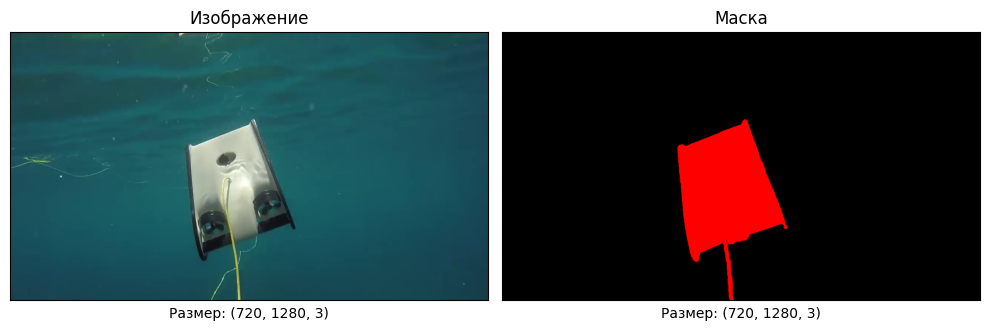

Классы в маске для изображения 5: [(0, 'Фон'), (4, 'Роботы')]


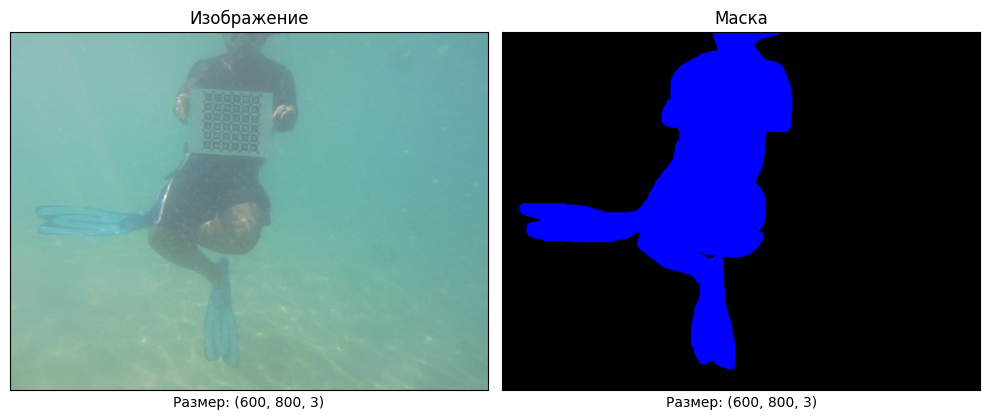

Классы в маске для изображения 166: [(0, 'Фон'), (1, 'Люди')]


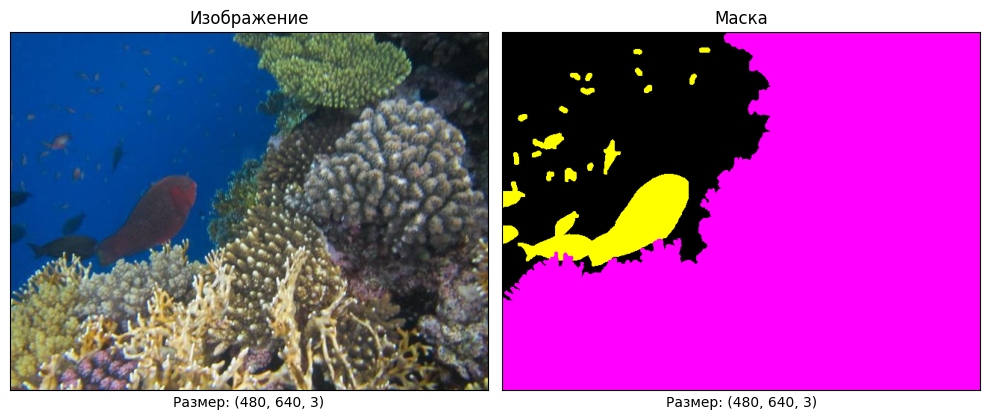

Классы в маске для изображения 335: [(0, 'Фон'), (5, 'Рифы'), (6, 'Рыбы')]


In [ ]:
data_path = "semantic-segmentation-of-underwater-imagery-suim"
train_df, val_df, test_df = create_dataframes(data_path)

print('train_df.shape:', train_df.shape)
print('val_df.shape:', val_df.shape)
print('test_df.shape:', test_df.shape)

intreat_image = (57, 12, 1112, 5, 166, 335)

for image in intreat_image:
    _, __, unique_colors = visualize_sample(train_df, index=image, figsize=(10, 5))
    class_names = [CLASS_NAMES.get(class_id, "Неизвестно") for class_id in unique_colors]
    print(f"Классы в маске для изображения {image}: {list(zip(unique_colors, class_names))}")


In [ ]:
train_df

,objects,mask
0,semantic-segmentation-of-underwater-imagery-su...,semantic-segmentation-of-underwater-imagery-su...
1,semantic-segmentation-of-underwater-imagery-su...,semantic-segmentation-of-underwater-imagery-su...
2,semantic-segmentation-of-underwater-imagery-su...,semantic-segmentation-of-underwater-imagery-su...
3,semantic-segmentation-of-underwater-imagery-su...,semantic-segmentation-of-underwater-imagery-su...
4,semantic-segmentation-of-underwater-imagery-su...,semantic-segmentation-of-underwater-imagery-su...
...,...,...
1367,semantic-segmentation-of-underwater-imagery-su...,semantic-segmentation-of-underwater-imagery-su...
1368,semantic-segmentation-of-underwater-imagery-su...,semantic-segmentation-of-underwater-imagery-su...
1369,semantic-segmentation-of-underwater-imagery-su...,semantic-segmentation-of-underwater-imagery-su...
1370,semantic-segmentation-of-underwater-imagery-su...,semantic-segmentation-of-underwater-imagery-su...


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Data preparation </h1>

In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Функция для загрузки и подготовки изображений
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    image = img_to_array(image) / 255.0  # Нормализация
    return image

# Функция для загрузки и подготовки масок
def preprocess_mask(mask_path):
    mask = load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='rgb')
    mask = img_to_array(mask)

    # Преобразуем цвета в метки классов
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
    for class_id, color in CLASS_COLORS.items():
        label_mask[np.all(mask == color, axis=-1)] = class_id

    return label_mask

# Функция для загрузки и подготовки данных
def load_data(df):
    images = []
    masks = []

    for idx, row in df.iterrows():
        image_path = row['objects']
        mask_path = row['mask']

        image = preprocess_image(image_path)
        mask = preprocess_mask(mask_path)

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Загрузка данных
train_images, train_masks = load_data(train_df)
val_images, val_masks = load_data(val_df)
test_images, test_masks = load_data(test_df)

# Проверка размерностей
print('train_images.shape:', train_images.shape)
print('train_masks.shape:', train_masks.shape)
print('val_images.shape:', val_images.shape)
print('val_masks.shape:', val_masks.shape)
print('test_images.shape:', test_images.shape)
print('test_masks.shape:', test_masks.shape)


train_images.shape: (1372, 256, 256, 3)
train_masks.shape: (1372, 256, 256)
val_images.shape: (153, 256, 256, 3)
val_masks.shape: (153, 256, 256)
test_images.shape: (110, 256, 256, 3)
test_masks.shape: (110, 256, 256)


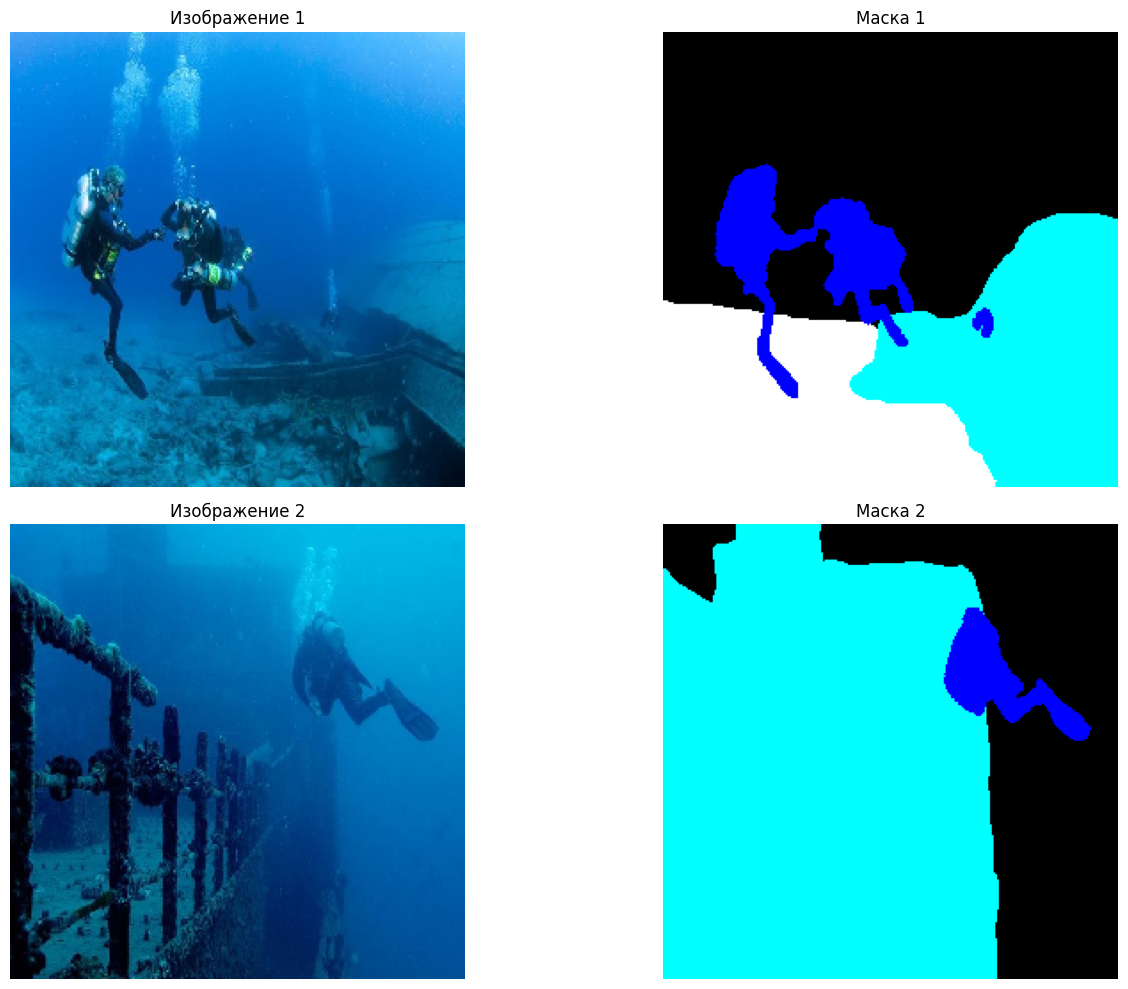

In [ ]:
# Функция для раскодирования масок из меток классов в RGB-цвета
def decode_mask(label_mask):
    height, width = label_mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

    for class_id, color in CLASS_COLORS.items():
        rgb_mask[label_mask == class_id] = color

    return rgb_mask

def visualize_images_and_masks(images, masks, num_samples=5):
    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Отображение изображения
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(images[i])
        plt.title(f"Изображение {i + 1}")
        plt.axis('off')

        # Отображение маски
        plt.subplot(num_samples, 2, 2 * i + 2)
        rgb_mask = decode_mask(masks[i])
        plt.imshow(rgb_mask)
        plt.title(f"Маска {i + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Пример использования
visualize_images_and_masks(train_images, train_masks, num_samples=2)


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> U-net build and fit </h1>

In [ ]:
class UNetModel:
    def __init__(self, input_size=(256, 256, 3), num_classes=8):
        self.input_size = input_size
        self.num_classes = num_classes

    def build_unet(self):
        inputs = Input(self.input_size)

        # Encoder
        c1 = Conv2D(64, (3, 3), padding='same')(inputs)
        c1 = BatchNormalization()(c1)
        c1 = Activation('relu')(c1)
        p1 = MaxPooling2D((2, 2))(c1)

        c2 = Conv2D(128, (3, 3), padding='same')(p1)
        c2 = BatchNormalization()(c2)
        c2 = Activation('relu')(c2)
        p2 = MaxPooling2D((2, 2))(c2)

        c3 = Conv2D(256, (3, 3), padding='same')(p2)
        c3 = BatchNormalization()(c3)
        c3 = Activation('relu')(c3)
        p3 = MaxPooling2D((2, 2))(c3)

        c4 = Conv2D(512, (3, 3), padding='same')(p3)
        c4 = BatchNormalization()(c4)
        c4 = Activation('relu')(c4)
        p4 = MaxPooling2D((2, 2))(c4)

        # Bridge
        c5 = Conv2D(1024, (3, 3), padding='same')(p4)
        c5 = BatchNormalization()(c5)
        c5 = Activation('relu')(c5)

        # Decoder with skip connections
        u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(512, (3, 3), padding='same')(u6)
        c6 = BatchNormalization()(c6)
        c6 = Activation('relu')(c6)

        u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(256, (3, 3), padding='same')(u7)
        c7 = BatchNormalization()(c7)
        c7 = Activation('relu')(c7)

        u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(128, (3, 3), padding='same')(u8)
        c8 = BatchNormalization()(c8)
        c8 = Activation('relu')(c8)

        u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
        u9 = concatenate([u9, c1])
        c9 = Conv2D(64, (3, 3), padding='same')(u9)
        c9 = BatchNormalization()(c9)
        c9 = Activation('relu')(c9)

        # Output with softmax and argmax
        outputs = Conv2D(self.num_classes, (1, 1), activation='softmax')(c9)
        argmax_output = Activation('softmax')(outputs)  # Сохраняем softmax для обучения
        final_output = Conv2D(self.num_classes, (1, 1), activation='softmax')(argmax_output)  # Для совместимости с loss

        # Модель для обучения возвращает вероятности
        model = Model(inputs=inputs, outputs=final_output)

        # Модель для предсказания возвращает классы
        prediction_model = Model(inputs=inputs, outputs=argmax_output)

        return model, prediction_model

    @staticmethod
    def sparse_dice_loss(y_true, y_pred, smooth=1e-5):
        """
        Вычисляет адаптированную DICE loss для sparse категорий (для задач сегментации изображений).

        DICE loss (коэффициент Сёренсена-Дайса) измеряет степень совпадения между двумя множествами.
        В данном случае, она используется для оценки совпадения между истинными метками (y_true)
        и предсказанными метками (y_pred) в задачах сегментации.

        Параметры:
            y_true (tensor): Истинные метки (ground truth), закодированные как целые числа (sparse).
            y_pred (tensor): Предсказанные вероятности для каждого класса (обычно выход модели после softmax).
            smooth (float): Малое значение для предотвращения деления на ноль (по умолчанию 1e-5).

        Возвращает:
            float: Значение DICE loss, которое стремится к 0 при идеальном совпадении.
        """

        # Приведение y_true к типу int32 для дальнейших операций
        y_true = K.cast(y_true, 'int32')

        # Преобразование y_true и y_pred в одномерные векторы (flatten)
        y_true_flat = K.flatten(y_true)  # Истинные метки
        y_pred_flat = K.flatten(K.argmax(y_pred, axis=-1))  # Предсказанные метки (выбираем класс с наибольшей вероятностью)

        # Вычисление пересечения (intersection) между y_true и y_pred
        # Сравниваем элементы y_true и y_pred, приводим результат к float32 и суммируем
        intersection = K.sum(K.cast(K.equal(y_true_flat, y_pred_flat), 'float32'))

        # Вычисление DICE loss
        # Формула: 1 - (2 * intersection + smooth) / (sum(y_true) + sum(y_pred) + smooth)
        dice_loss = 1 - (2. * intersection + smooth) / (K.sum(K.cast(y_true_flat, 'float32')) + K.sum(K.cast(y_pred_flat, 'float32')) + smooth)

        return dice_loss


In [14]:
BATCH_SIZE = 16
NUM_EPOCH = 100

# Инициализация модели
model, prediction_model = UNetModel(
    input_size=(256, 256, 3),
    num_classes=len(CLASS_COLORS)
    ).build_unet()

# Компиляция модели с учетом sparse масок
# sparse_categorical_crossentropy — функция потерь для задач классификации с sparse метками
# Она вычисляет кросс-энтропию между истинными метками (целые числа) и предсказанными вероятностями классов.
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy', # Функция потерь для sparse меток
    metrics=['accuracy']
)

# Обучение
history = model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    epochs=NUM_EPOCH,
    batch_size=BATCH_SIZE
)

# Оценка модели на тестовом наборе данных
test_loss, test_accuracy = model.evaluate(test_images, test_masks)
print('---' * 30)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.1857 - loss: 2.0191 - val_accuracy: 0.1197 - val_loss: 2.0182
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 91s 507ms/step - accuracy: 0.3627 - loss: 1.9926 - val_accuracy: 0.2140 - val_loss: 2.0052
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 82s 512ms/step - accuracy: 0.4358 - loss: 1.9758 - val_accuracy: 0.3251 - val_loss: 1.9897
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 44s 515ms/step - accuracy: 0.5859 - loss: 1.9606 - val_accuracy: 0.3862 - val_loss: 1.9677
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 81s 508ms/step - accuracy: 0.6121 - loss: 1.9462 - val_accuracy: 0.4689 - val_loss: 1.9466
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 83s 521ms/step - accuracy: 0.6179 - loss: 1.9354 - val_accuracy: 0.6137 - val_loss: 1.9237
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 82s 519ms/step - accuracy: 0.6223 - loss: 1.9254 - val_accuracy: 0.6486 - val_loss: 1.9090
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 82s 521ms/step - accuracy: 0.6206 - loss: 1.9114 - va

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 582ms/step


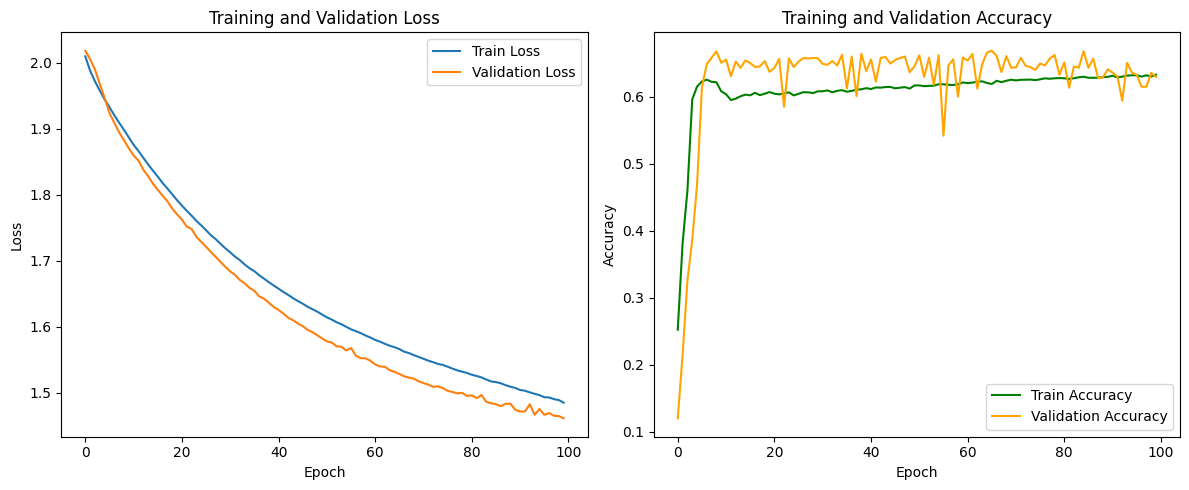

In [15]:
train_losses = history.history['loss']
val_losses = history.history['val_loss']
train_accuracies = history.history['accuracy']
val_accuracies = history.history['val_accuracy']

predicted_masks = prediction_model.predict(test_images)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> U-net predict </h1>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


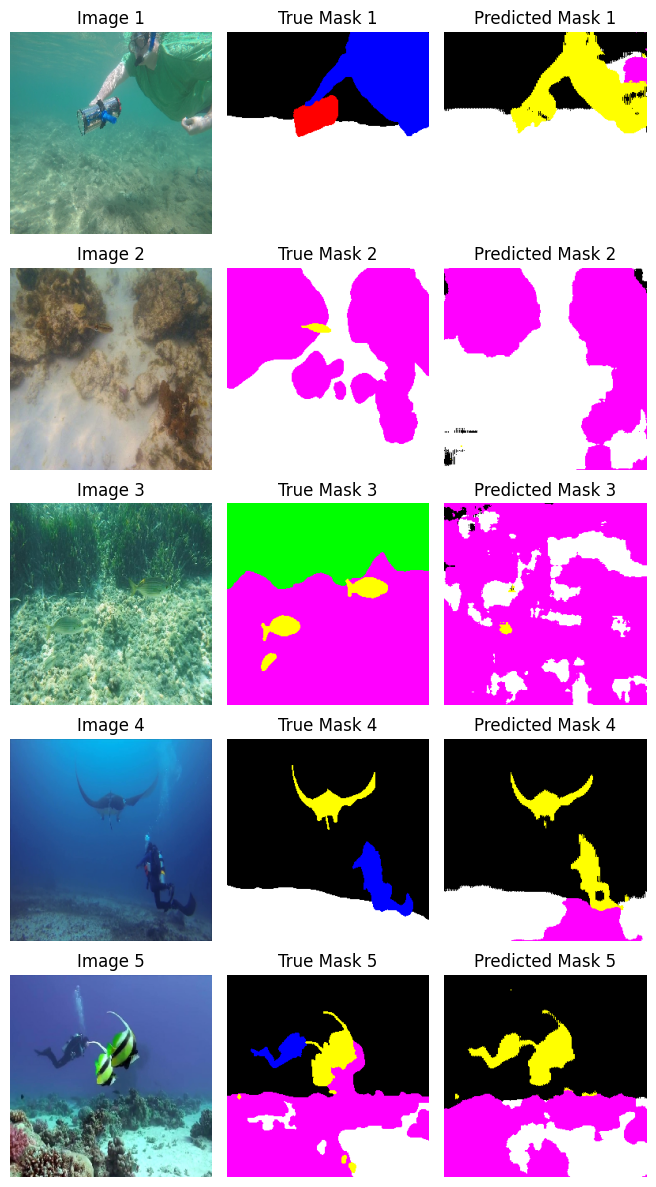

In [20]:
NUMBER_SAMPLES = 5

# Словарь цветов и классов
CLASS_COLORS = {
    0: [0, 0, 0],     # Фон
    1: [0, 0, 255],   # Люди (синий)
    2: [0, 255, 0],   # Растения (зеленый)
    3: [0, 255, 255], # Обломки (голубой)
    4: [255, 0, 0],   # Роботы (красный)
    5: [255, 0, 255], # Рифы (фиолетовый)
    6: [255, 255, 0], # Рыбы (желтый)
    7: [255, 255, 255] # Дно (белый)
}

# Функция для декодирования масок
def decode_mask(label_mask):
    height, width = label_mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

    for class_id, color in CLASS_COLORS.items():
        rgb_mask[label_mask == class_id] = color

    return rgb_mask

# Выбираем первые картинки из тестового набора
sample_images = test_images[:NUMBER_SAMPLES]
sample_masks = test_masks[:NUMBER_SAMPLES]

# Делаем прогноз и декодируем маски в цвета RGB
predicted_masks = prediction_model.predict(sample_images)
decoded_true_masks = [decode_mask(mask) for mask in sample_masks]

# Округляем вероятности до меток классов
predicted_classes = np.argmax(predicted_masks, axis=-1)
# Декодируем предсказанные маски
decoded_predictions = [decode_mask(pred_mask) for pred_mask in predicted_classes]


plt.figure(figsize=(11, 12))

for i in range(NUMBER_SAMPLES):
    # Исходное изображение
    plt.subplot(NUMBER_SAMPLES, NUMBER_SAMPLES, i * NUMBER_SAMPLES + 1)
    plt.imshow(sample_images[i])
    plt.title(f'Image {i+1}')
    plt.axis('off')

    # Истинная маска (декодированная)
    plt.subplot(NUMBER_SAMPLES, NUMBER_SAMPLES, i * NUMBER_SAMPLES + 2)
    plt.imshow(decoded_true_masks[i])  # Истинная маска в цветах
    plt.title(f'True Mask {i+1}')
    plt.axis('off')

    # Предсказанная маска
    plt.subplot(NUMBER_SAMPLES, NUMBER_SAMPLES, i * NUMBER_SAMPLES + 3)
    plt.imshow(decoded_predictions[i])  # Маска в цветах
    plt.title(f'Predicted Mask {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()
